In [1]:
import os
import shutil
from glob import glob
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from skimage.filters import roberts, sobel
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [2]:
# Directories for Healthy and Sick images
healthy_dir = '/kaggle/input/breat-cancer/Breast Cancer/Healthy'
sick_dir = '/kaggle/input/breat-cancer/Breast Cancer/Sick'

In [3]:
# Get list of image paths for Healthy and Sick images
healthy_image_paths = glob(os.path.join(healthy_dir, '*.jpg'))
sick_image_paths = glob(os.path.join(sick_dir, '*.jpg'))

if not healthy_image_paths:
    print("Error: No healthy images found in the specified directory.")
else:
    print(f"Found {len(healthy_image_paths)} healthy images in the directory.")

if not sick_image_paths:
    print("Error: No sick images found in the specified directory.")
else:
    print(f"Found {len(sick_image_paths)} sick images in the directory.")

Found 178 healthy images in the directory.
Found 100 sick images in the directory.


In [4]:
# Combine Healthy and Sick image paths
all_image_paths = healthy_image_paths + sick_image_paths

# Create labels (0 for Healthy, 1 for Sick)
labels = [0] * len(healthy_image_paths) + [1] * len(sick_image_paths)

In [5]:
# Function to apply masks and save images
def apply_masks_and_save(image_paths, dest_dir):
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        edge_roberts = roberts(img)
        edge_sobel = sobel(img)

        # Stack the original, Roberts, and Sobel images
        stacked_image = np.stack((img, edge_roberts, edge_sobel), axis=-1)

        # Create the destination path
        file_name = os.path.basename(img_path)
        dest_path = os.path.join(dest_dir, file_name)

        # Save the stacked image
        cv2.imwrite(dest_path, (stacked_image * 255).astype(np.uint8))

In [6]:
# Apply masks and save images in new directories
masked_healthy_dir = 'masked_images/Healthy'
masked_sick_dir = 'masked_images/Sick'

In [7]:
os.makedirs(masked_healthy_dir, exist_ok=True)
os.makedirs(masked_sick_dir, exist_ok=True)

apply_masks_and_save(healthy_image_paths, masked_healthy_dir)
apply_masks_and_save(sick_image_paths, masked_sick_dir)

# Get new image paths after applying masks
masked_healthy_image_paths = glob(os.path.join(masked_healthy_dir, '*.jpg'))
masked_sick_image_paths = glob(os.path.join(masked_sick_dir, '*.jpg'))

# Combine Healthy and Sick image paths again
all_image_paths = masked_healthy_image_paths + masked_sick_image_paths


In [8]:
# Split the data into training, validation, and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, stratify=train_labels, random_state=42)

# Directories for training, validation, and testing datasets
train_dir = 'dataset_split/train'
val_dir = 'dataset_split/val'
test_dir = 'dataset_split/test'

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [9]:
# Function to copy images to their respective directories
def copy_images(image_paths, labels, dest_dir):
    for img_path, label in zip(image_paths, labels):
        label_dir = os.path.join(dest_dir, 'Healthy' if label == 0 else 'Sick')
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)

# Copy images to training, validation, and testing directories
copy_images(train_paths, train_labels, train_dir)
copy_images(val_paths, val_labels, val_dir)
copy_images(test_paths, test_labels, test_dir)

print(f'Number of training images: {len(train_paths)}')
print(f'Number of validation images: {len(val_paths)}')
print(f'Number of testing images: {len(test_paths)}')

Number of training images: 166
Number of validation images: 56
Number of testing images: 56


In [10]:
# Image transformations without augmentations
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [11]:
# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=transform['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=transform['test'])

# Print the number of images for training, validation, and testing
print(f'Number of training images: {len(train_dataset)}')
print(f'Number of validation images: {len(val_dataset)}')
print(f'Number of testing images: {len(test_dataset)}')

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Number of training images: 166
Number of validation images: 56
Number of testing images: 56


In [12]:
# Model Definition
model_densenet121 = models.densenet121(pretrained=True)
model_densenet121.classifier = nn.Sequential(
    nn.Linear(model_densenet121.classifier.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_densenet121 = model_densenet121.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 53.3MB/s]


In [13]:
# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_densenet121.parameters(), lr=0.00001)

In [14]:
# Function to train and validate the model
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            if i % 100 == 0:
                print(f'Training batch {i}/{len(train_loader)}')
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()

            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                if i % 100 == 0:
                    print(f'Validation batch {i}/{len(val_loader)}')
                inputs, labels = inputs.to(device), labels.to(device).float()

                outputs = model(inputs)
                outputs = outputs.squeeze()
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / total

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')


In [15]:
# Train and validate the model
train_and_validate(model_densenet121, criterion, optimizer, train_loader, val_loader, num_epochs=15)

Starting epoch 1/15
Training batch 0/6
Validation batch 0/2
Epoch 1/15, Train Loss: 0.6841, Train Accuracy: 0.5000, Validation Loss: 0.6737, Validation Accuracy: 0.6429
Starting epoch 2/15
Training batch 0/6
Validation batch 0/2
Epoch 2/15, Train Loss: 0.6287, Train Accuracy: 0.7470, Validation Loss: 0.6557, Validation Accuracy: 0.6429
Starting epoch 3/15
Training batch 0/6
Validation batch 0/2
Epoch 3/15, Train Loss: 0.5895, Train Accuracy: 0.8494, Validation Loss: 0.6439, Validation Accuracy: 0.6607
Starting epoch 4/15
Training batch 0/6
Validation batch 0/2
Epoch 4/15, Train Loss: 0.5668, Train Accuracy: 0.8434, Validation Loss: 0.6272, Validation Accuracy: 0.6786
Starting epoch 5/15
Training batch 0/6
Validation batch 0/2
Epoch 5/15, Train Loss: 0.5379, Train Accuracy: 0.8735, Validation Loss: 0.6104, Validation Accuracy: 0.7679
Starting epoch 6/15
Training batch 0/6
Validation batch 0/2
Epoch 6/15, Train Loss: 0.5182, Train Accuracy: 0.8554, Validation Loss: 0.5929, Validation Acc

In [16]:
def show_predictions(images, labels, predictions, num_images=10):
    plt.figure(figsize=(20, 10))
    for idx in range(num_images):
        plt.subplot(2, num_images//2, idx+1)
        image = images[idx].transpose((1, 2, 0))  # Reorder dimensions for plotting
        image = (image * 255).astype(np.uint8)
        plt.imshow(image)
        true_label = 'Healthy' if labels[idx] == 0 else 'Sick'
        pred_label = 'Healthy' if predictions[idx] == 0 else 'Sick'
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.show()

In [17]:
def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_images = []  # To store images for visualization
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if i % 100 == 0:
                print(f'Testing batch {i}/{len(test_loader)}')
            inputs, labels = inputs.to(device), labels.to(device).float()

            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_images.extend(inputs.cpu().numpy())  # Store images

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Sick'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Classification report
    print(classification_report(all_labels, all_predictions, target_names=['Healthy', 'Sick']))

    # Show predictions
    show_predictions(all_images, all_labels, all_predictions)


Testing batch 0/2
Test Loss: 0.4763, Test Accuracy: 0.8393


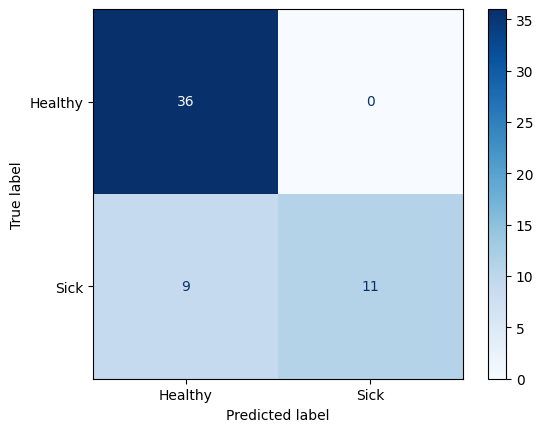

Sensitivity: 0.5500
Specificity: 1.0000
              precision    recall  f1-score   support

     Healthy       0.80      1.00      0.89        36
        Sick       1.00      0.55      0.71        20

    accuracy                           0.84        56
   macro avg       0.90      0.78      0.80        56
weighted avg       0.87      0.84      0.82        56



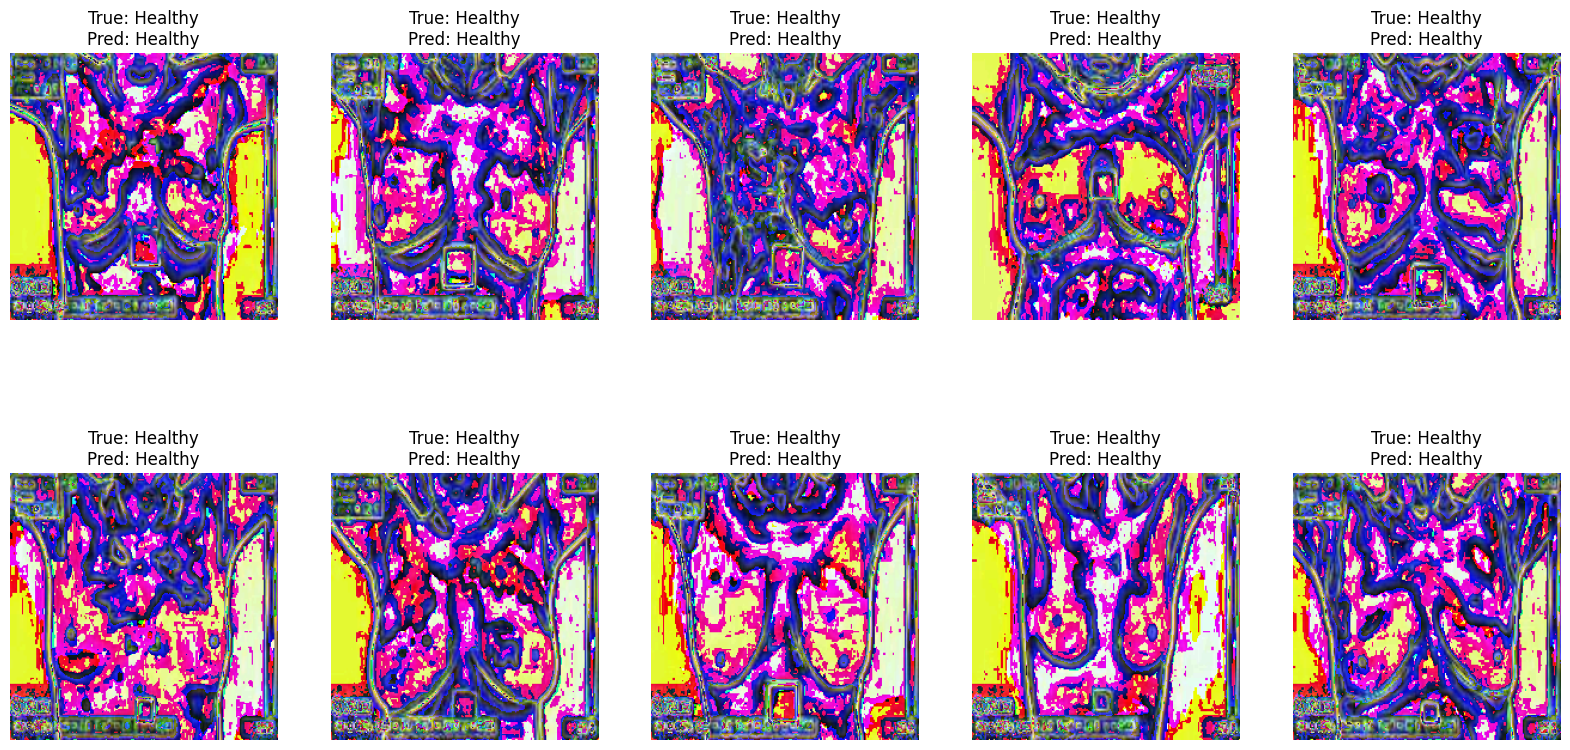

In [18]:
# Test the model
test_model(model_densenet121, test_loader)